# NSDUH Drug Sequence Analysis Part 9:  Classification Analysis
## University of Oklahoma
__February 26, 2021__

### Prescription Tree Analysis
This uses decision tree analysis to predict prescription drug abuse.

### Approach
* Read in the labeled partitioned dataset
* Using prescription drug use as a 1/0 variable, determine a tree model to predit classification

In [1]:
"""
Import python modules
"""

# General libraries
import pandas as pd
import numpy as np
import copy
import os
import sys
import pathlib, itertools
import time
import random
import pickle
import json
import pathutils as pu
import mlflow
from math import dist, sqrt
from textwrap import wrap


# SciKit Learn Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, confusion_matrix, balanced_accuracy_score, RocCurveDisplay
from sklearn.metrics import f1_score, mean_squared_error, roc_curve, auc, average_precision_score, precision_recall_curve

# Graphics libraries
import matplotlib.pyplot as plt
import pydotplus
import matplotlib.image as pltimg
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.sans-serif'] = 'Gill Sans MT'
mpl.rcParams['font.family'] = 'sans-serif'



HOME_DIR = pathlib.Path.home()
CW_DIR = pathlib.Path.cwd()

FIGW = 12
FIGH = 5
FONTSIZE = 8
FIGURESIZE = (FIGW,FIGH)

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE


### Set file names, etc.

In [2]:
# Set working parameters
datapath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Data3/'
workingpath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Code3/'
outpath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Output3/'
hugefiles = 'C:/Users/mjbea/huge_files/'
year = '2016_2017_2018_2019'
jsondict = datapath + 'NSDUH_field.json'
n_clusters = 13
alpha = 0.60

# Setup filenames
newclustpkl =  workingpath + 'stable_13_clust_2016_2017_2018_2019_newclust.pkl'
treemodelgrid = workingpath + 'NSDUH_' + str(year) + '_dt_model.pkl'
lcmodelgrid = 'NSDUH_' + str(year) + '_lc_model.pkl'
treegraph = outpath + 'illct_dtree_5level.png'
dtfscoreout = outpath + 'illct_dt_fscore.png'
lcfscoreout = outpath + 'illct_lc_fscore.png'
dtcmout = outpath + 'dt_confusion_matrix_opt.png'
lccmout = outpath + 'lc_confusion_matrix_opt.png'
dtrocout = outpath + 'dt_roc.png'
lcrocout = outpath + 'lc_roc.png'
modtxtsumry = outpath + 'classifiers_txtsumry.txt'

# Get translation dictionaries
stryear = '2016_2017_2018_2019'

# Drug name and indices are called by a user-defined function.
ident, rawafuvals, afuvals, drugnames, drugorder, drugnums, drugposition, startdemog, demographics = pu.surveyvars(year)

# Decode dictionaries for NSDUH variables:
f1 = open(jsondict, 'r')
nsduhDecoder = json.load(f1)
f1.close()


### Helper Utilities
These methods calculate cluster stats such as inertia, average inertia, center of cluster, and nearest medoid to center, and a descriptive AFU path that characterizes the medoid.

In [3]:

"""
getcenter(df)
Calculates and returns the center and inertia of a cluster.  Uses weights from survey.
"""
def getcenter(df):
    df['AFUARRAY'] = df.apply(lambda row: np.matrix(row['AFUVECT']).A[0],axis=1)
    center = np.average(a=df['AFUARRAY'], weights=df['YRWEIGHT'])
    df['DISTSQ'] = df.apply(lambda row: euclidean(row['AFUARRAY'],center)**2, axis=1)
    df['WTDISTSQ'] = df.apply(lambda row: row['DISTSQ'] * row['YRWEIGHT'], axis=1)
    inertia = df['WTDISTSQ'].sum()
    return center, inertia


"""
getmedoid(df)
Calculates and returns medoid of a cluster
"""
def getmedoid(df, clustcenter):
#    clustcenter, clustinertia = getcenter(df)
    df['distfrommean'] = df.apply(lambda row: euclidean(np.matrix(row['AFUVECT']).A[0], clustcenter), axis=1)
    medoidstr = df.loc[df['distfrommean'].idxmin()]['AFUVECT']
    medoid = np.matrix(medoidstr).A[0]
    return medoid


"""
arrayToPath(medoid)
Converts a medoid to a path list
"""
def arrayToPath(array):
    afupath = {}
    i = 0
    for item in array:
        pathstep = {drugposition[i]: float(item)}   # The type conversion is necessary for saving in JSON
        if item != 991:
            afupath.update(pathstep)
        i += 1
    return afupath


"""
makenewpath(df, drugposition)
Recreates the AFUPATH variable from the AFUVECT variable
"""
def makenewpath(df, drugposition):
    vect = []
    i = 0
    for position in df['AFUVECT']:
        if position < 991:
            vect.append((drugposition[i], position))
        i += 1
        vect.sort(key=lambda x:x[1])
    return vect


"""
makeunwnewpath(df, drugposition)
Recreates the AFUPATH variable from the AFUVECT variable
"""
def makeunwnewpath(df, drugposition):
    vect = []
    for position in df['AFUPATH']:
        vect.append(position[0])
    return vect


"""
minafuillicit(df)
Determintes a minimum AFU and logical flag for illicit drugs
"""
def minafuillicit(df):
    minillicit = min(df[4], df[5], df[6],
                 df[7], df[8], df[9])
    return minillicit



""" fscore_thresh_plot()
Identify the maximum f-score and threshold that obtains that score.
Generate a plot of the f-score and print the maximized values.  Beta is
the recall escalation parameter and defaults to 1.
"""
def fscore_thresh_plot(model,Xval,yval,beta=1,modelname='',fname=''):
    # Set font sizes
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

    proba_val = model.predict_proba(Xval)
    precision, recall, thresholds = precision_recall_curve(yval, proba_val[:,1])
    
    precision = precision[0:len(thresholds)]
    recall = recall[0:len(thresholds)]
    fscore = (1+beta**2)*precision*recall/(beta**2*precision+recall)
    
    df = pd.concat([pd.DataFrame(thresholds,columns=['threshold']), 
                pd.DataFrame(precision,columns=['precision']), 
                pd.DataFrame(recall,columns=['recall']), 
                pd.DataFrame(fscore,columns=['fscore'])],axis=1)
    
    maxfscore = max(df['fscore'])
    bestthreshold = df.iloc[df[['fscore']].idxmax()]['threshold'].values[0]
#    plttext = ('Maximum f-score: ' + str(round(maxfscore,5)) + '\nThreshold for maximum F1-score: ' + 
#                str(round(bestthreshold,5)) + '\nBeta=' + str(beta))
    plttext = ('Maximum F1-score: ' + str(round(maxfscore,5)) + '\nThreshold for maximum F1-score: ' + 
                str(round(bestthreshold,5)))

    fig, ax = plt.subplots()
    plt.ylim(0,1)
    ax.plot('threshold','fscore',data=df)
    ax.axvline(x=bestthreshold,color='r',linestyle='--')
    x = .25*max(df['threshold'])
    y = .25*maxfscore
    ax.text(x,y,plttext)

    ax.set(xlabel='Threshold', ylabel='F1-score')
    ax.set_title('\n'.join(wrap('F1-score vs Threshold:  ' + modelname)),{'fontsize': BIGGER_SIZE})
    
    if fname != '':
        plt.savefig(fname)
    plt.show()
    
    diagscores = {'maxfscore': maxfscore, 'bestthreshold': bestthreshold}
    
    return diagscores


""" confusion_plot()
Generate a formatted confusion matrix plot.  Takes model, testset true values,
testset input, and a threshold probability.  Prints the plot.
"""
def confusion_plot(model, Xval, yval, threshold, labels='',title='',fname='',sweight=None):
    # Set font sizes
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    ypred = (model.predict_proba(Xval)[:,1] >= threshold).astype(bool)
    df_cm = pd.DataFrame(confusion_matrix(yval,ypred,sample_weight=sweight).astype(int), labels, labels)
    plt.figure(figsize = (7,5))
    plt.title(title)
#    sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Gill Sans MT'})
    ax = sns.heatmap(df_cm,annot=True,fmt='d',linewidths=0.5,cbar=False,cmap='Greys')

    for t in ax.texts:
        t.set_text('{:,d}'.format(int(t.get_text())))

    plt.yticks(va="center")
    if fname != '':
        plt.savefig(fname)
    plt.show()
    
    return


In [4]:
drugposition

{0: 'start',
 1: 'TOBACCO',
 2: 'ALCOHOL',
 3: 'MARIJUANA',
 4: 'COCAINE',
 5: 'PRESCRIPTIONS',
 6: 'HALLUCINOGEN',
 7: 'INHALANTS',
 8: 'HEROIN',
 9: 'METHAMPHETAMINE'}

## Classification Analyses
This sections compares two methods, Decision Tree and Logistic Regression, in their ability to predict the use of illicit drugs given AFUs for tobacco, alcohol, and marijuana.

### Method
* Set logical variable for illicit drug use based upon use of inhalants, hallucinogens, cocaine, heroin, methamphetamine, and prescription drugs.
* Set AFU values for illicit drugs based upon the minimum AFU for the category.
* For both illicit drugs and the quasi-legal ones, develop an AFU suitable for classification models.  In this case, the AFU is an inverse:
$$\text{INVAFU} = 1/\text{AFU} \text{ if AFU} < 991, \text{ 0 otherwise}$$
* Run a logistic regression model to determine classification
* Run a decision tree model to determine classification
* Compare performance using confusion matrix, F1 score, and AUROC and AUPRC curves

In [5]:
# Identify prescription drug abusers with a 1/0 classification variable
nsduh = pd.read_pickle(newclustpkl)
nsduh['MINILLCT'] = nsduh['AFUVECT'].apply(lambda row: minafuillicit(row))
nsduh['LOGCLILLCT'] = nsduh['MINILLCT'].apply(lambda x: 1 if x < 991 else 0)
nsduh['INVILLCTAFU'] = nsduh['MINILLCT'].apply(lambda x: 1/x if x < 991 else 0)
nsduh['INVTOBAFU'] = nsduh['AFUVECT'].apply(lambda x: 1/x[1] if x[1] < 991 else 0)
nsduh['INVALCAFU'] = nsduh['AFUVECT'].apply(lambda x: 1/x[2] if x[2] < 991 else 0)
nsduh['INVMARAFU'] = nsduh['AFUVECT'].apply(lambda x: 1/x[3] if x[3] < 991 else 0)
nsduh['TOBALC'] = nsduh['INVTOBAFU'] * nsduh['INVALCAFU']
nsduh['TOBMAR'] = nsduh['INVTOBAFU'] * nsduh['INVMARAFU']
nsduh['ALCMAR'] = nsduh['INVALCAFU'] * nsduh['INVMARAFU']
nsduh['TOBALCMAR'] = nsduh['INVTOBAFU'] * nsduh['INVALCAFU'] * nsduh['INVMARAFU']
nsduh.head()

,RESPID,AFUVECT,labels,CATAG6,SVCFLAG,IRSEX,IRMARIT,NEWRACE2,EDUHIGHCAT,IRWRKSTAT,...,MINILLCT,LOGCLILLCT,INVILLCTAFU,INVTOBAFU,INVALCAFU,INVMARAFU,TOBALC,TOBMAR,ALCMAR,TOBALCMAR
0,201611635143.0,"[0, 16, 15, 20, 991, 991, 991, 991, 991, 991]",3,3,0,2,1,1,4,4,...,991.0,0,0.0,0.062500,0.066667,0.050000,0.004167,0.003125,0.003333,0.000208
1,201661056143.0,"[0, 21, 15, 15, 991, 991, 991, 991, 991, 991]",3,4,0,1,1,7,1,1,...,991.0,0,0.0,0.047619,0.066667,0.066667,0.003175,0.003175,0.004444,0.000212
2,201683666143.0,"[0, 18, 18, 20, 991, 991, 991, 991, 991, 991]",3,3,0,2,1,1,4,1,...,991.0,0,0.0,0.055556,0.055556,0.050000,0.003086,0.002778,0.002778,0.000154
3,201659497143.0,"[0, 22, 16, 20, 991, 991, 991, 991, 991, 991]",3,2,0,1,4,7,3,1,...,991.0,0,0.0,0.045455,0.062500,0.050000,0.002841,0.002273,0.003125,0.000142
4,201663899143.0,"[0, 14, 16, 15, 991, 991, 991, 991, 991, 991]",3,3,0,1,4,2,2,1,...,991.0,0,0.0,0.071429,0.062500,0.066667,0.004464,0.004762,0.004167,0.000298


In [6]:
# Get the frequnency of illicit drug use
print('The frequency of illicit drug use in the dataset is:', nsduh['LOGCLILLCT'].value_counts()[1]/nsduh.shape[0])


The frequency of illicit drug use in the dataset is: 0.3171330962186447


# Decision Tree Classification
Using the tobacco, alcohol, and marijuana AFU values, a decision tree classifier is used to predict further illicit drug use.
* Tree depth is limited to 4 to keep interpretability of the tree model high
* A grid search is performed to find the best model.  The AUROC value is used to find the best model because the data is fairly balanced (32% in the positive class)

In [7]:
# Setup features for Decision Tree Classification
allfeatures = ['INVTOBAFU', 'INVALCAFU', 'INVMARAFU', 'YRWEIGHT']
features = ['INVTOBAFU', 'INVALCAFU', 'INVMARAFU']

X = nsduh[allfeatures]
y = nsduh['LOGCLILLCT'].astype(int)

# Hold out 25% of data for a test set
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Create column of weights for later use and pull out of train and test datasets
Xvalweights = Xval['YRWEIGHT']
Xtrainweights = Xtrain['YRWEIGHT']
Xtrain.drop('YRWEIGHT', axis=1, inplace=True)
Xval.drop('YRWEIGHT', axis=1, inplace=True)

## Z-score Normalization
Because all variables were on the same scale, z-score normalization did not improve results.  So it is turned off.

In [8]:
# Try z-score normalization
zscore = False
if zscore:
    Xtrain = pd.DataFrame(StandardScaler().fit_transform(Xtrain))
    Xval = pd.DataFrame(StandardScaler().fit_transform(Xval))

In [9]:
# Generate a set of random parameters from which to perform a random CV

# Maximum number of levels in tree
max_depth = [1,2,3,4]
# Minimum number of samples required to split a node
min_samples_split = [.025,.05,.10]
# Create the grid
params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}
print(params)

{'max_depth': [1, 2, 3, 4], 'min_samples_split': [0.025, 0.05, 0.1]}


In [10]:
# Random search of parameters, using 3 fold cross validation, 20 combinations
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(estimator=dt, param_grid=params, scoring='roc_auc', cv=5, verbose=1)
fit_params={'sample_weight': Xtrainweights}

# Run the cross-validation
dt_grid.fit(Xtrain, ytrain, **fit_params)

# Save output to pickle file
pickle.dump(dt_grid, open(treemodelgrid, 'wb'))

# Display results
print('Best score (AUROC) of Decision Tree Grid Search CV was:', dt_grid.best_score_)
print('Best parameter set was:', dt_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best score (AUROC) of Decision Tree Grid Search CV was: 0.8285554479880262
Best parameter set was: {'max_depth': 4, 'min_samples_split': 0.025}


### Evaluate the decision tree classifier

In [11]:
# Show the feature importance scores and print basic summaries to text out
dtmod = dt_grid.best_estimator_
y_pred_dt = dtmod.predict(Xval)

variableimps = dtmod.feature_importances_
dttxtout = open(modtxtsumry,'w')
print('ILLICIT DRUG CLASSIFIER:  DECISION TREE MODEL\n\n', file=dttxtout)
print('Best score (AUROC) of Decision Tree Grid Search CV was:', dt_grid.best_score_, file=dttxtout)
print('Best parameter set was:', dt_grid.best_params_, file=dttxtout)

# Print basic accuracy metrics
print('DECISION TREE CLASSIFIER PERFORMANCE:\n',
      'Balanced accuracy: {:.2f} - Average precision {:.2f}'
      .format(balanced_accuracy_score(yval, y_pred_dt),
              average_precision_score(yval, y_pred_dt)), file=dttxtout)

shortdrugnames = ['TOBACCO','ALCOHOL','MARIJUANA']
print('\n\n***** FEATURE IMPORTANCE SCORES *****', file = dttxtout)
i = 0
for item in shortdrugnames:
    print(item, ':', variableimps[i], file=dttxtout)
    i += 1


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Gill Sans MT


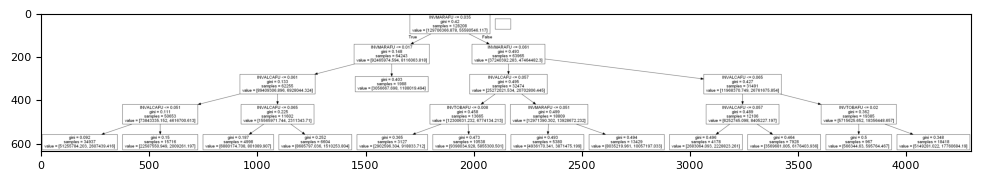

In [12]:
# Display the tree
dtmod = dt_grid.best_estimator_

data = tree.export_graphviz(dtmod, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png(treegraph)

img=pltimg.imread(treegraph)
imgplot = plt.imshow(img)
plt.show()

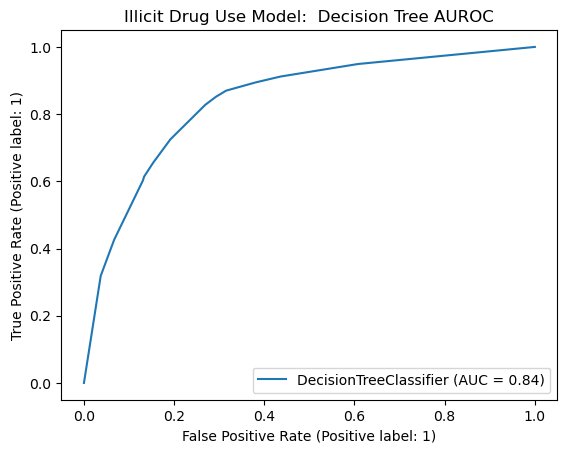

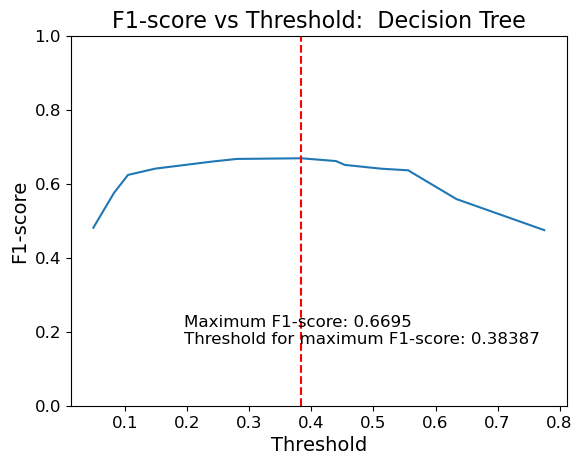

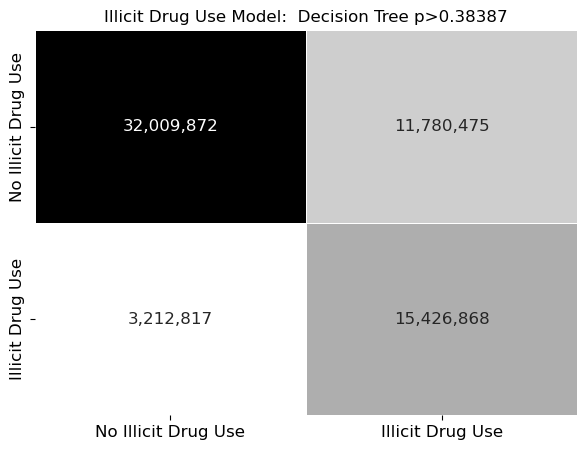

In [13]:
# Predict outcomes from decision tree model
dtmod = dt_grid.best_estimator_
y_pred_dt = dtmod.predict(Xval)

# Set plot options
targetnames = ['No Illicit Drug Use', 'Illicit Drug Use']
mpl.rcParams.update(mpl.rcParamsDefault)

# Generate AUROC Curve
fig, ax = plt.subplots(ncols=1)
ax.set_title('Illicit Drug Use Model:  Decision Tree AUROC')
ax = RocCurveDisplay.from_estimator(dtmod, Xval, yval, sample_weight = Xvalweights, ax=ax)
plt.savefig(dtrocout)

# Display the fscore by threshold plot
dt_fthresh = fscore_thresh_plot(dt_grid.best_estimator_,Xval,yval,modelname='Decision Tree',
                                fname=dtfscoreout)

# Print confusion matrix for p>bestthreshold
pval = dt_fthresh['bestthreshold']
title = 'Illicit Drug Use Model:  Decision Tree p>'+str(round(pval,5))
confusion_plot(dt_grid.best_estimator_, Xval, yval, pval, labels=targetnames,title=title,
               fname=dtcmout,sweight=Xvalweights)

# Logistic Regression
Using the tobacco, alcohol, and marijuana AFU values, a logicstic regression classifier is used to predict further illicit drug use.
* All linear and second order combinations of the features are included
* A grid search is performed to find the best model.  The AUROC value is used to find the best model because the data is fairly balanced (32% in the positive class)

In [14]:
# Setup features for Decision Tree Classification
allfeatures = ['INVTOBAFU', 'INVALCAFU', 'INVMARAFU', 'TOBALC', 'TOBMAR', 'ALCMAR', 'TOBALCMAR', 'YRWEIGHT']
features = ['INVTOBAFU', 'INVALCAFU', 'INVMARAFU', 'TOBALC', 'TOBMAR', 'ALCMAR', 'TOBALCMAR']
features = ['INVTOBAFU', 'INVALCAFU', 'INVMARAFU']

X = nsduh[allfeatures]
y = nsduh['LOGCLILLCT'].astype(int)

# Hold out 25% of data for a test set
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Create column of weights for later use and pull out of train and test datasets
Xvalweights = Xval['YRWEIGHT']
Xtrainweights = Xtrain['YRWEIGHT']
Xtrain.drop('YRWEIGHT', axis=1, inplace=True)
Xval.drop('YRWEIGHT', axis=1, inplace=True)

In [15]:
# Try z-score normalization
zscore = False
if zscore:
    Xtrain = pd.DataFrame(StandardScaler().fit_transform(Xtrain))
    Xval = pd.DataFrame(StandardScaler().fit_transform(Xval))

In [16]:
# Setup parameter grid for logistic regression
params = {'fit_intercept' : [True, False], 'penalty' : ['none','l1', 'l2','elasticnet']}
print(params)

{'fit_intercept': [True, False], 'penalty': ['none', 'l1', 'l2', 'elasticnet']}


In [17]:
# Random search of parameters, using 3 fold cross validation, 20 combinations
lc = LogisticRegression()
lc_grid = GridSearchCV(estimator=lc, param_grid=params, scoring='roc_auc', cv=5, verbose=1)
fit_params={'sample_weight': Xtrainweights}

# Run the cross-validation
lc_grid.fit(Xtrain, ytrain, **fit_params)

# Save output to pickle file
pickle.dump(lc_grid, open(lcmodelgrid, 'wb'))

# Display results
print('Best score (AUROC) of Logistic Regression Grid Search CV was:', lc_grid.best_score_)
print('Best parameter set was:', lc_grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\mjbea\anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mjbea\anaconda3\envs\py38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with th

Best score (AUROC) of Logistic Regression Grid Search CV was: 0.8312531617586203
Best parameter set was: {'fit_intercept': True, 'penalty': 'none'}


C:\Users\mjbea\anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
# Show the coefficients scores and print basic summaries to text out
lcmod = lc_grid.best_estimator_
y_pred_lc = lcmod.predict(Xval)

print('\n\n\nILLICIT DRUG CLASSIFIER:  LOGISTIC REGRESSION MODEL\n\n', file=dttxtout)
print('Best score (AUROC) of Logistic Regression Grid Search CV was:', lc_grid.best_score_, file=dttxtout)
print('Best parameter set was:', lc_grid.best_params_, file=dttxtout)

# Print basic accuracy metrics
print('LOGISTIC REGRESSION CLASSIFIER PERFORMANCE:\n',
      'Balanced accuracy: {:.2f} - Average precision {:.2f}'
      .format(balanced_accuracy_score(yval, y_pred_lc),
              average_precision_score(yval, y_pred_lc)), file=dttxtout)

shortdrugnames = ['TOBACCO','ALCOHOL','MARIJUANA','TOBACCOxALCOHOL', 'TOBACCOxMARIJUANA',
                  'ALCOHOLxMARIJUANA', 'TOBACCOxALCOHOLxMARIJUANA']
coefs = lcmod.coef_
print('\n\n***** COEFFICIENTS *****', file = dttxtout)
print('INTERCEPT:', lcmod.intercept_[0], file=dttxtout)
i = 0
for item in shortdrugnames:
    print(item, ':', coefs[0][i], file=dttxtout)
    i += 1
dttxtout.close()

Logistic regression classifier performance:
Balanced accuracy: 0.75 - Average precision 0.53


C:\Users\mjbea\AppData\Local\Temp/ipykernel_10340/688035651.py:102: RuntimeWarning: invalid value encountered in true_divide
  fscore = (1+beta**2)*precision*recall/(beta**2*precision+recall)


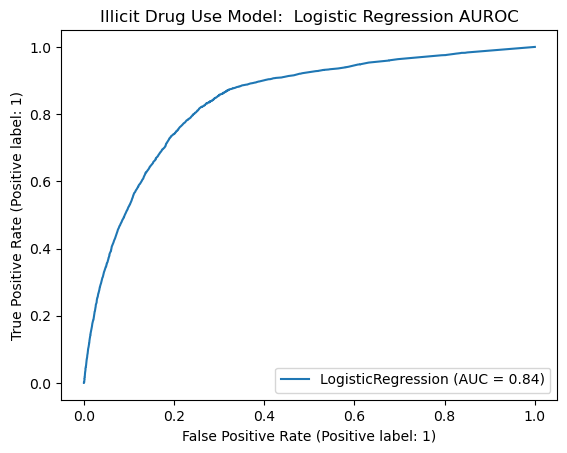

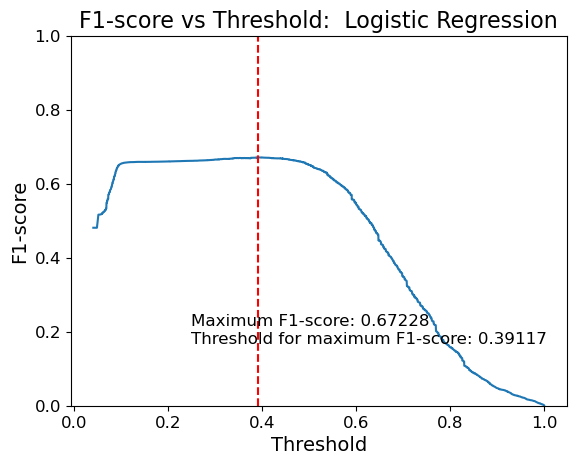

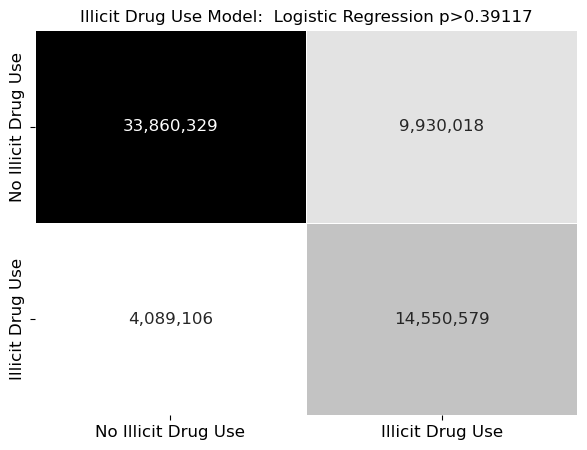

In [19]:
# Predict outcomes from decision tree model
lcmod = lc_grid.best_estimator_
y_pred_lc = lcmod.predict(Xval)

# Compare the Random Forest and Balanced Random Forest methods
print('Logistic regression classifier performance:')
print('Balanced accuracy: {:.2f} - Average precision {:.2f}'
      .format(balanced_accuracy_score(yval, y_pred_lc),
              average_precision_score(yval, y_pred_lc)))

# Set plot options
targetnames = ['No Illicit Drug Use', 'Illicit Drug Use']
mpl.rcParams.update(mpl.rcParamsDefault)

# Generate AUROC Curve
fig, ax = plt.subplots(ncols=1)
ax.set_title('Illicit Drug Use Model:  Logistic Regression AUROC')
ax = RocCurveDisplay.from_estimator(lcmod, Xval, yval, sample_weight = Xvalweights, ax=ax)
plt.savefig(lcrocout)

# Display the fscore by threshold plot
lc_fthresh = fscore_thresh_plot(lc_grid.best_estimator_,Xval,yval,modelname='Logistic Regression',
                                fname=lcfscoreout)

# Print confusion matrix for p>bestthreshold
pval = lc_fthresh['bestthreshold']
title = 'Illicit Drug Use Model:  Logistic Regression p>'+str(round(pval,5))
confusion_plot(lc_grid.best_estimator_, Xval, yval, pval, labels=targetnames,title=title,
               fname=lccmout,sweight=Xvalweights)

In [21]:
# Get Logistic Regression p-values
from scipy.stats import norm

def logit_p1value(model, x):
   
    p1 = model.predict_proba(x)
    n1 = len(p1)
    m1 = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    answ = np.zeros((m1, m1))
    for i in range(n1):
        answ = answ + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p1[i,1] * p1[i, 0]
    vcov = np.linalg.inv(np.matrix(answ))
    se = np.sqrt(np.diag(vcov))
    t1 =  coefs/se  
    p1 = (1 - norm.cdf(abs(t1))) * 2
    return p1

print(logit_p1value(lcmod, Xtrain))


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.75925312e-05 0.00000000e+00 9.11891854e-01 8.73692495e-02]
